In [1]:
import gc
import os, types
from botocore.client import Config
import ibm_boto3
import warnings
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# Sklearn imports
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score,confusion_matrix, roc_curve 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, Normalizer
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
warnings.simplefilter(action='ignore', category=FutureWarning)

!pip3 install ibm-watson-machine-learning --user | tail -n 1
!pip3 install ibm-watson-pipelines --user | tail -n 1

import os

from ibm_watson_machine_learning import APIClient
from ibm_watson_pipelines import WatsonPipelines
from ibm_watson_pipelines.cpd_paths import CpdScope, CpdPath



  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
watson-core 2.1.0 requires protobuf<5,>=4.21.6, but you have protobuf 3.20.3 which is incompatible.
onnx 1.13.1 requires protobuf>=4.21, but you have protobuf 3.20.3 which is incompatible.


In [2]:
import itc_utils.flight_service as itcfs

readClient = itcfs.get_flight_client()

nb_data_request = {
    'data_name': """Model Data Initial.csv""",
    'interaction_properties': {
        #'row_limit': 500,
        'infer_schema': 'true',
        'infer_as_varchar': 'false'
    }
}

flightInfo = itcfs.get_flight_info(readClient, nb_data_request=nb_data_request)

df = itcfs.read_pandas_and_concat(readClient, flightInfo, timeout=240)
df.head(10)




,CUST_ID,GENDER,MARITAL_STATUS,NATIONALITY,EDUCATION,EMPLOYMENT,OCCUPATION,AGE_IN_YEARS,NO_OF_DIFFERENT_PRODUCTS,LOAN_DEFAULT
0,10,Female,n/a,n/a,n/a,Housewife,n/a,61.097878,1,F
1,20,Female,n/a,n/a,n/a,n/a,n/a,57.982204,1,F
2,30,Female,n/a,Greek Cypriot,n/a,Housewife,n/a,45.859001,1,F
3,40,n/a,n/a,Greek Cypriot,n/a,n/a,n/a,NaN,1,F
4,50,Female,n/a,Greek Cypriot,n/a,Private Company / Partnership,Other Professionals,55.956194,1,F
5,60,n/a,n/a,Greek Cypriot,n/a,n/a,n/a,44.164271,1,F
6,70,Male,Married,Greek Cypriot,n/a,Government - Semi-Government,Skilled Worker,54.203970,2,F
7,110,Female,Married,British,n/a,Retired,n/a,53.571526,4,F
8,156,Male,n/a,Other,n/a,Retired,n/a,88.292950,3,F
9,173,Female,Married,British,n/a,Private Company / Partnership,Salesmen,44.539357,5,F


1.1 Impute missing values for Numerical and Character variables

In [3]:
df= df.drop(['CUST_ID'], axis=1)  
cols = [c for c in df.columns]
cat_cols = [c for c in df.columns if df[c].dtype == 'object' ]
num_cols = [c for c in df.columns if df[c].dtype!='object']

for col in cols:
    print (col , df[col].isna().sum())
    
for col in cat_cols:
    df[col].fillna("No info", inplace = True)
 
    for col in num_cols:
        df[col] = df[col].fillna (df[col].median())
        
    
df.head()



GENDER 0
MARITAL_STATUS 0
NATIONALITY 0
EDUCATION 0
EMPLOYMENT 0
OCCUPATION 0
AGE_IN_YEARS 8
NO_OF_DIFFERENT_PRODUCTS 0
LOAN_DEFAULT 0


,GENDER,MARITAL_STATUS,NATIONALITY,EDUCATION,EMPLOYMENT,OCCUPATION,AGE_IN_YEARS,NO_OF_DIFFERENT_PRODUCTS,LOAN_DEFAULT
0,Female,n/a,n/a,n/a,Housewife,n/a,61.097878,1,F
1,Female,n/a,n/a,n/a,n/a,n/a,57.982204,1,F
2,Female,n/a,Greek Cypriot,n/a,Housewife,n/a,45.859001,1,F
3,n/a,n/a,Greek Cypriot,n/a,n/a,n/a,36.260096,1,F
4,Female,n/a,Greek Cypriot,n/a,Private Company / Partnership,Other Professionals,55.956194,1,F


2.1 Categorical features

In [4]:

df_categorical = df[cat_cols].copy()
for col in cat_cols:
    if df_categorical[col].nunique() == 2:
        df_categorical[col], _ = pd.factorize(df_categorical[col])
    else:
        df_categorical = pd.get_dummies(df_categorical, columns=[col])

df_categorical.head(3)

,LOAN_DEFAULT,GENDER_Female,GENDER_Male,GENDER_n/a,MARITAL_STATUS_Divorced,MARITAL_STATUS_Married,MARITAL_STATUS_Single,MARITAL_STATUS_Widowed,MARITAL_STATUS_n/a,NATIONALITY_British,...,OCCUPATION_Salesmen,OCCUPATION_Skilled Worker,OCCUPATION_Solicitors,OCCUPATION_Students,OCCUPATION_Teachers / Professors,OCCUPATION_Technicians,OCCUPATION_Travel Agents/Airline Employees,OCCUPATION_University / College,OCCUPATION_Unskilled Worker,OCCUPATION_n/a
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


2.2 Feature scalling

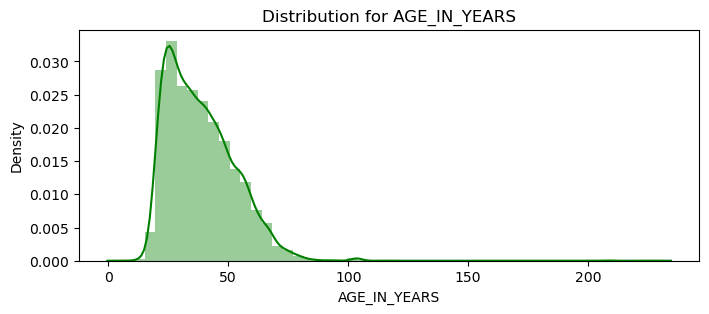

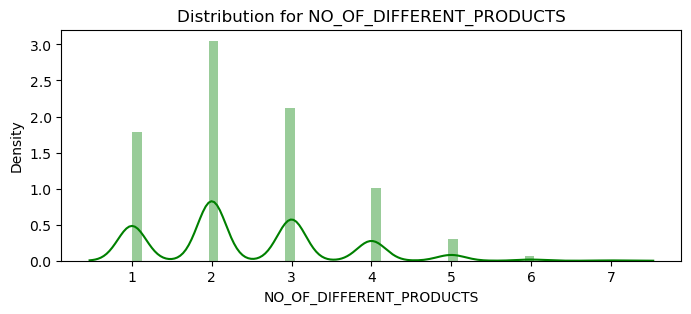

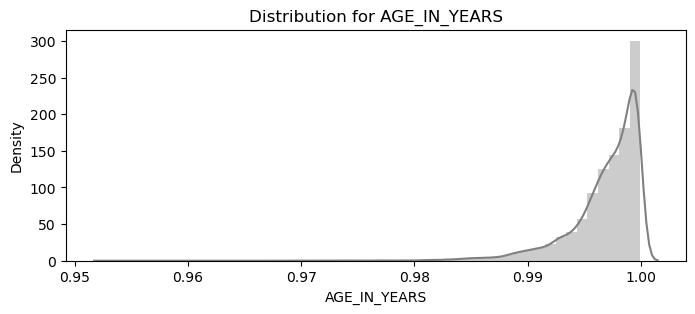

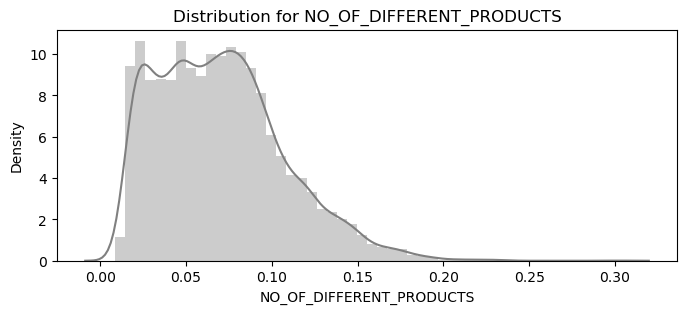

In [5]:
def distplot(feature, frame, color='g'):
    plt.figure(figsize=(8,3))
    plt.title("Distribution for {}".format(feature))
    ax = sns.distplot(frame[feature], color= color)

df[num_cols].describe()
for feat in num_cols: distplot(feat, df)
df_std = pd.DataFrame( Normalizer().fit(df[num_cols]).transform(df[num_cols]),
                       columns=num_cols)
for feat in num_cols: distplot(feat, df_std, color='gray')
 


# 10 fold - Cross-Validation

In [6]:
class Model():
    def __init__(self, classifier, frame, metrics, fixed_params = {},
                 test_size=0.2, random_seed=50):
        self.estimator = classifier
        self.seed = random_seed
        self.metrics = metrics
        self.hyperparameters = {}
        self.fixed_params = fixed_params
        self.fixed_params['random_state'] = random_seed
        if classifier == KNeighborsClassifier:
            del self.fixed_params['random_state']

        # First divide data in learning set and final test set
        self.train, self.test = train_test_split(frame, test_size=test_size, random_state= self.seed)
        self.predictors = [c for c in self.train.columns if c not in ['CUST_ID', 'LOAN_DEFAULT']]

    def grid_search(self, fit_metric, params, num_folds=10):
        """ Save the best params to self.hyperparameters. """
        print(self.fixed_params)
        gs = GridSearchCV(self.estimator(**self.fixed_params), param_grid= params,
                          scoring=self.metrics, cv=num_folds, refit= fit_metric)
        gs.fit(self.train[self.predictors], self.train['LOAN_DEFAULT'])
        self.hyperparameters = gs.best_params_
        return [(m, gs.cv_results_['mean_test_{}'.format(m)][gs.best_index_]) for m in self.metrics]
  
 
    def train_and_evaluate_test(self):
        """ Train classifier on the full train set and evaluate the performance on the test set. """
        params = {**self.hyperparameters, **self.fixed_params}
        self.clf = self.estimator(**params).fit(self.train[self.predictors], self.train['LOAN_DEFAULT'])
        self.m1 = float(0.70)
        y_pred = self.clf.predict(self.test[self.predictors])
       ## self.y_pred = y_pred
        y_prob = self.clf.predict_proba(self.test[self.predictors])[:, 1]
        cm = confusion_matrix(self.test['LOAN_DEFAULT'], y_pred)
        print("Confusion Matrix:", cm)
        
        plt.figure(figsize=(9,9))
        sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
        plt.ylabel('Actual label');
        plt.xlabel('Predicted label');
        plt.title('Accuracy Score Heat Map', size = 15);
        plt.show()    
        
        fper, tper, thresholds = roc_curve(self.test['LOAN_DEFAULT'], y_prob) 
       
        plt.plot(fper, tper, color='orange', label='ROC')
        plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend()
        plt.show()    

        results = list()
        for m in self.metrics:
            if m == 'roc_auc':
                # For calculating roc auc we need the probability of target==1
                results.append((m, roc_auc_score(self.test['LOAN_DEFAULT'], y_prob)))
            else:
                # For the other metrics we can simply use the predicted label (0 or 1)
                results.append((m, eval("{}_score".format(m))(self.test['LOAN_DEFAULT'], y_pred)))
                self.accuracy = eval("{}_score".format(m))(self.test['LOAN_DEFAULT'], y_pred)
        return results

def print_result(results, sufix = ""):
    """ Function for printing the results nicely. """
    msg = ""
    for result in results:
        msg += "| {}: {:.4f} ".format(result[0], result[1])
    print("{}- {}".format(msg, sufix))

 Testing models

In [7]:
df_processed = pd.concat([df_std, df_categorical], axis=1)
metrics = ['roc_auc', 'accuracy']
df_processed

,AGE_IN_YEARS,NO_OF_DIFFERENT_PRODUCTS,LOAN_DEFAULT,GENDER_Female,GENDER_Male,GENDER_n/a,MARITAL_STATUS_Divorced,MARITAL_STATUS_Married,MARITAL_STATUS_Single,MARITAL_STATUS_Widowed,...,OCCUPATION_Salesmen,OCCUPATION_Skilled Worker,OCCUPATION_Solicitors,OCCUPATION_Students,OCCUPATION_Teachers / Professors,OCCUPATION_Technicians,OCCUPATION_Travel Agents/Airline Employees,OCCUPATION_University / College,OCCUPATION_Unskilled Worker,OCCUPATION_n/a
0,0.999866,0.016365,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.999851,0.017244,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.999762,0.021801,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.999620,0.027568,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.999840,0.017868,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10092,0.996574,0.082702,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10093,0.994563,0.104132,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
10094,0.995853,0.090979,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
10095,0.999310,0.037131,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


{'max_iter': 100, 'solver': 'saga', 'random_state': 50}
| roc_auc: 0.7312 | accuracy: 0.8029 - cross-validation
Confusion Matrix: [[1511   53]
 [ 369   87]]


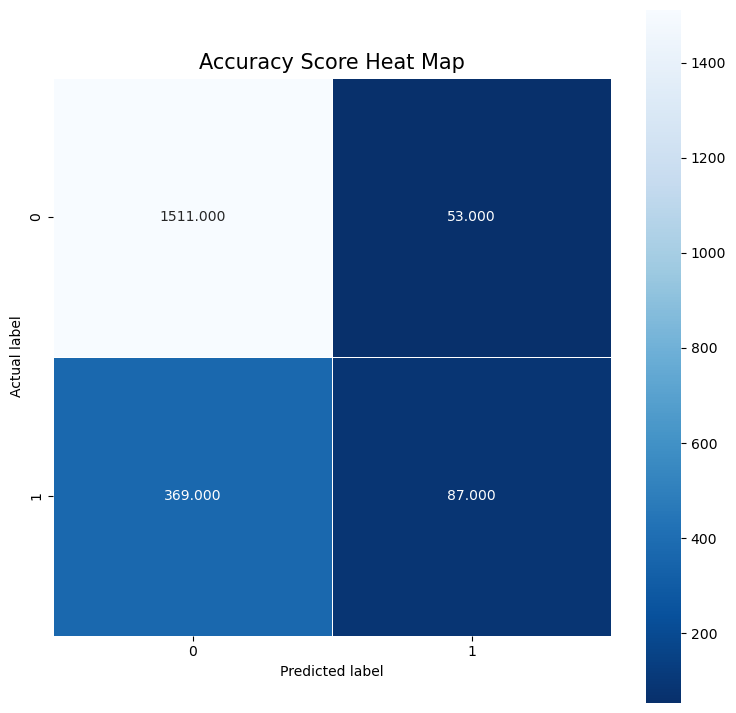

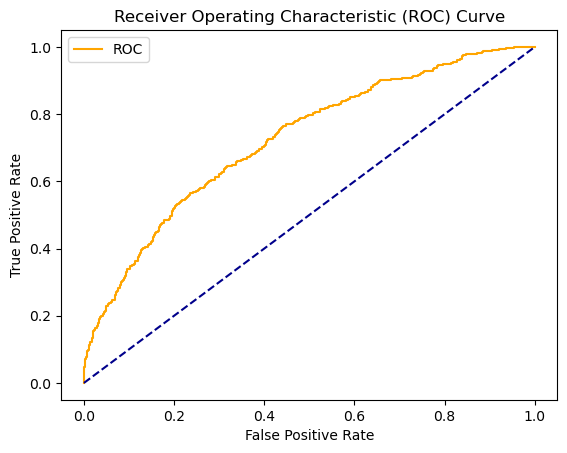

| roc_auc: 0.7236 | accuracy: 0.7911 - test set
Best hyperparameters: {'C': 1.0}


In [8]:

def logistic_regression(frame, grid):
    logit = Model(LogisticRegression, frame, metrics, fixed_params= {'max_iter': 100 , 'solver' : 'saga'})
    print_result(logit.grid_search('roc_auc', grid, num_folds= 5), "cross-validation")
    print_result(logit.train_and_evaluate_test(), "test set")
    print("Best hyperparameters:", logit.hyperparameters)
    return logit.accuracy, logit.clf, logit.m1
m , n, m1 = logistic_regression(df_processed, {'C': np.logspace(0, 1, 10, base=10)})


In [9]:
m,n,m1

(0.7910891089108911, LogisticRegression(random_state=50, solver='saga'), 0.7)

In [13]:
from ibm_watson_machine_learning import APIClient

TRAINING_DATA_ASSET_CPD_PATH = 'cpd:///spaces/8a4bb896-8b3f-4bbd-b1e6-df80b7a7d3e6/assets/fcaa3e12-accb-4dd8-be9f-2682dae4498a' 

MODEL_NAME = 'LOAN_DEFAULT_Notebook'

# Replace these values with your actual WML credentials
wml_credentials = {  "version": "4.7",
    "url": "https://cpd-cpd-instance.apps.daffy-hrb7pxfs.cloud.techzone.ibm.com/",
    "username": "ckroustalis",
    "password": "predicta1!",
    "instance_id": "openshift"

}
wml_credentials
TRAINING_DATA_ASSET_CPD_PATH
wml_client = APIClient(wml_credentials)
wml_client



software_spec_id = wml_client.software_specifications.get_uid_by_name('runtime-22.2-py3.10')
space_scope = CpdPath.from_string(TRAINING_DATA_ASSET_CPD_PATH)
space_id = space_scope.scope_id()
wml_client.set.default_space(space_id)


'SUCCESS'

In [41]:
models = wml_client.repository.get_model_details()['resources']
model_id = next((m['metadata']['id'] for m in models if m['metadata']['name'] == MODEL_NAME), None)

model_deployments = wml_client.deployments.get_details()
for deployment in model_deployments['resources']:
    deployment_id = deployment['metadata']['id']
    asset_id = deployment['entity']['asset']['id']
    if asset_id == model_id:
        print('Deleting deployment id', deployment_id)
        wml_client.deployments.delete(deployment_id)

if model_id:
    print('Deleting model id', model_id)
    wml_client.repository.delete(model_id)

wml_client.repository.list_models()
print(model_id)

------------------------------------  -----------------------------------------------  ------------------------  --------------  ----------  ----------------
ID                                    NAME                                             CREATED                   TYPE            SPEC_STATE  SPEC_REPLACEMENT
ddb123d5-0ddd-4786-84da-1a28bcc38c78  Model AI - P10 Snap Boosting Machine Classifier  2023-09-22T10:14:22.002Z  wml-hybrid_0.1  supported
d13b5d68-1ad4-4ea5-85ba-34bcf5e3302e  LOAN_DEFAULT                                     2023-09-20T10:19:12.002Z  pmml_4.2        supported
------------------------------------  -----------------------------------------------  ------------------------  --------------  ----------  ----------------
None


In [42]:


model_props = {
    wml_client.repository.ModelMetaNames.NAME: "{}".format(MODEL_NAME),
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_id,
    wml_client.repository.ModelMetaNames.TYPE: "scikit-learn_1.1",
    wml_client.repository.ModelMetaNames.TAGS: ["cpdctl-demo-model"]
}
model_props



{'name': 'LOAN_DEFAULT_Notebook',
 'software_spec': 'b56101f1-309d-549b-a849-eaa63f77b2fb',
 'type': 'scikit-learn_1.1',
 'tags': ['cpdctl-demo-model']}

In [43]:
model_details = wml_client.repository.store_model(model=n, meta_props=model_props, training_data=df_processed.drop(['LOAN_DEFAULT'], axis=1), training_target=df_processed.LOAN_DEFAULT)
model_details 
    



{'entity': {'hybrid_pipeline_software_specs': [],
  'label_column': 'LOAN_DEFAULT',
  'schemas': {'input': [{'fields': [{'name': 'AGE_IN_YEARS',
       'type': 'float64'},
      {'name': 'NO_OF_DIFFERENT_PRODUCTS', 'type': 'float64'},
      {'name': 'GENDER_Female', 'type': 'uint8'},
      {'name': 'GENDER_Male', 'type': 'uint8'},
      {'name': 'GENDER_n/a', 'type': 'uint8'},
      {'name': 'MARITAL_STATUS_Divorced', 'type': 'uint8'},
      {'name': 'MARITAL_STATUS_Married', 'type': 'uint8'},
      {'name': 'MARITAL_STATUS_Single', 'type': 'uint8'},
      {'name': 'MARITAL_STATUS_Widowed', 'type': 'uint8'},
      {'name': 'MARITAL_STATUS_n/a', 'type': 'uint8'},
      {'name': 'NATIONALITY_British', 'type': 'uint8'},
      {'name': 'NATIONALITY_Croates', 'type': 'uint8'},
      {'name': 'NATIONALITY_Greek', 'type': 'uint8'},
      {'name': 'NATIONALITY_Greek Cypriot', 'type': 'uint8'},
      {'name': 'NATIONALITY_Lebanese', 'type': 'uint8'},
      {'name': 'NATIONALITY_Other', 'type': 

In [44]:
models = wml_client.repository.get_model_details()['resources']
model_id = next((m['metadata']['id'] for m in models if m['metadata']['name'] == MODEL_NAME), None)
model_id


'77862049-8e92-45b8-817f-a955d9d92be7'

In [45]:
model_path = f"{space_scope.scope()}/assets/{model_id}"
model_path



'cpd:///spaces/8a4bb896-8b3f-4bbd-b1e6-df80b7a7d3e6/assets/77862049-8e92-45b8-817f-a955d9d92be7'

In [46]:
results = {
  "trained_model": model_path,
  "evaluation_result": m1
}
print(results)

{'trained_model': 'cpd:///spaces/8a4bb896-8b3f-4bbd-b1e6-df80b7a7d3e6/assets/77862049-8e92-45b8-817f-a955d9d92be7', 'evaluation_result': 0.7}


In [48]:
api_key = '1cgCoLRH-5Kp4Y67XMm9FjdBwGxR-3prvleXZ9qK4pt0'
cpdaas_url = 'https://cpd-cpd-instance.apps.daffy-hrb7pxfs.cloud.techzone.ibm.com'
#pipelines_client = WatsonPipelines.from_apikey(api_key, url=cpdaas_url)
# Initialize the Watson Machine Learning client
pipelines_client = WatsonPipelines.new_instance()


res = pipelines_client.store_results(results)

print('DONE')

Running outside of Watson Pipelines - storing results in the local filesystem for testing purposes...

  output paths:
    - "trained_model": .ibm_watson_pipelines/results/trained_model
    - "evaluation_result": .ibm_watson_pipelines/results/evaluation_result
DONE
